In [3]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import time
from joblib import Parallel, delayed
sys.path.append('../')

from packages import actv_analysis, svm
import seaborn as sns

In [2]:
# Get the current directory
current_dir = os.getcwd()

# Go two directories up
up_two_dir = os.path.dirname(current_dir)
twoup = os.path.dirname(os.path.dirname(os.path.realpath(__file__)))

print(up_two_dir)

NameError: name '__file__' is not defined

In [10]:
def get_random_units(units, num_units, sort_by, percentage_true=1, **quadrants):
    
    if sort_by == 'fit':
        fit = pd.DataFrame(np.array([[unit.coeff1, unit.coeff2, unit.r_sqrd] for unit in units]), 
                      columns=['coeff1', 'coeff2', 'rsqrd'])
        # Define quadrant conditions
        conditions = {
            'Q1': (fit['coeff1'] > 0) & (fit['coeff2'] > 0) & (fit['rsqrd'] > 0.1),
            'Q2': (fit['coeff1'] < 0) & (fit['coeff2'] > 0) & (fit['rsqrd'] > 0.1),
            'Q3': (fit['coeff1'] < 0) & (fit['coeff2'] < 0) & (fit['rsqrd'] > 0.1),
            'Q4': (fit['coeff1'] > 0) & (fit['coeff2'] < 0) & (fit['rsqrd'] > 0.1),
        }
    if sort_by == 'ktau':
        fit = pd.DataFrame(np.array([[unit.kendall_stats['averaged_across_sizes']['tau'],
                                  unit.kendall_stats['averaged_across_numbers']['tau']] for unit in units]),
                       columns=['ktau_num', 'ktau_size'])
        
        conditions = {
            'Q1': (fit['ktau_num'] > 0) & (fit['ktau_size'] > 0),
            'Q2': (fit['ktau_num'] < 0) & (fit['ktau_size'] > 0),
            'Q3': (fit['ktau_num'] < 0) & (fit['ktau_size'] < 0),
            'Q4': (fit['ktau_num'] > 0) & (fit['ktau_size'] < 0),
        }

    # Filter indices based on specified quadrants
    selected_indices_true = [index for quad, cond in conditions.items() if quadrants.get(quad, False) for index in fit[cond].index]
    selected_indices_false = [index for quad, cond in conditions.items() if not quadrants.get(quad, False) for index in fit[cond].index]

    # Determine number of units to sample from each group
    num_true = int(num_units * percentage_true)
    num_false = num_units - num_true
    
    # Check if there are enough units to sample from
    if num_true > len(selected_indices_true):
        print(f"Not enough true units to sample from. Required: {num_true}, Available: {len(selected_indices_true)}")
        return None

    if num_false > len(selected_indices_false):
        print(f"Not enough false units to sample from. Required: {num_false}, Available: {len(selected_indices_false)}")
        return None

    # Randomly sample indices
    random_indices_true = np.random.choice(selected_indices_true, num_true, replace=False) if num_true > 0 else []
    random_indices_false = np.random.choice(selected_indices_false, num_false, replace=False) if num_false > 0 else []

    # Combine and return indices
    random_indices = np.concatenate([random_indices_true, random_indices_false])
    return random_indices

In [22]:
# Parameters
relus = list(range(4, 5))
epochs = np.arange(0, 91, 10)
num_units = 200
layer_numunits = {'relu1':290400, 'relu2':186624, 'relu3':64896, 'relu4':64896, 'relu5':43264}

dir_path = os.path.dirname(os.path.realpath('..'))
save_to_folder = f"{dir_path}/dataframes/SVM_predictions"

exps = range(10)
percentage_true_values = np.arange(0, 1.1, 0.1)

for relu in relus:
    for epoch in [90,0]:
        for net in range(8, 11):
            
            pkl_filename = f'../../pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'
            print(f'Loading {pkl_filename}..')
            with open(pkl_filename, 'rb') as f:
                units = pickle.load(f)
                    
            print(f'Loading actv ..')
            actv_net = actv_analysis.get_actv_net(net=net, relu=relu, epoch=epoch)
            actv = actv_net.reshape(layer_numunits[f'relu{relu}'], 10, 10, 500)
                    
            for percentage_true in percentage_true_values:

                random_units = get_random_units(units, num_units=num_units, sort_by='ktau', percentage_true=percentage_true, Q1=True, Q3=True).astype(int)

                start_time = time.time()
                y_preds = Parallel(n_jobs=-1)(delayed(svm.SVM_fit)(units=random_units, actv=actv, exp=exp) for exp in exps)
                end_time = time.time()
                print(f"Took {end_time - start_time} seconds to run.")

                for exp in exps:
                    filename = f'../../csv/SVM_prediction_He_untrained_net{net}_relu{relu}_epoch{epoch}_{num_units}_units_Q1_or_Q3_{percentage_true*100:.0f}percent_sortbyktau_exp{exp}_Oct2023.csv'
                    pd.Series(y_preds[exp]).to_csv(filename, index=True)
                    #print(f'Saved results to {filename}')

Loading ../../pkl/4to20/network8_Relu4_epoch90_4to20.pkl..
Loading actv ..
--- 97.67441082000732 seconds ---
Took 26.193187713623047 seconds to run.
Took 23.975268125534058 seconds to run.
Took 22.936753034591675 seconds to run.
Took 23.225800037384033 seconds to run.
Took 23.887094020843506 seconds to run.
Took 23.69901394844055 seconds to run.
Took 23.892518758773804 seconds to run.
Took 24.531195163726807 seconds to run.
Took 23.17245888710022 seconds to run.
Took 23.377886056900024 seconds to run.
Took 23.597764015197754 seconds to run.
Loading ../../pkl/4to20/network9_Relu4_epoch90_4to20.pkl..
Loading actv ..
--- 95.84253096580505 seconds ---
Took 26.512481212615967 seconds to run.
Took 24.873929977416992 seconds to run.
Took 24.320308923721313 seconds to run.
Took 23.70267105102539 seconds to run.
Took 23.505356073379517 seconds to run.
Took 23.570516109466553 seconds to run.
Took 23.918851852416992 seconds to run.
Took 23.953600883483887 seconds to run.
Took 24.41763186454773 se

In [19]:
net=1; relu=4; epoch=90
num_units=200
percentage_true=0.7
df_acc = pd.DataFrame(columns=['net','relu','epoch','percentage','exp','cong_acc','incong_acc'])

for net in range(1,8):
    for epoch in [0,90]:
        for percentage_true in np.arange(0,1.1,0.1):
            for exp in range(0,10):
    
                test_csv = f'../../csv/svm_test_set{exp}_4to20.csv'
                pred_csv = f'../../csv/SVM_prediction_He_untrained_net{net}_relu{relu}_epoch{epoch}_{num_units}_units_Q1_or_Q3_{percentage_true*100:.0f}percent_sortbyktau_exp{exp}_Oct2023.csv'
                test_exp = pd.read_csv(test_csv, index_col=0)
                num_dists=np.abs(test_exp['num1']-test_exp['num2'])*2
                correct_answers = svm.get_y(test_exp).to_numpy()
                svm_answers = pd.read_csv(pred_csv)['0'].to_numpy()
                is_equal = np.equal(correct_answers, svm_answers)

                cong = test_exp.index[((test_exp['num1']<test_exp['num2'])&(test_exp['sz1']<test_exp['sz2']))|((test_exp['num1']>test_exp['num2'])&(test_exp['sz1']>test_exp['sz2']))]
                incong = np.setdiff1d(range(len(test_exp)), cong)
                incong_acc = np.sum(is_equal[incong])/len(is_equal[incong])
                cong_acc = np.sum(is_equal[cong])/len(is_equal[cong])
                info = [net,relu,epoch,percentage_true,exp,cong_acc,incong_acc]
                # Append info to df_acc
                df_acc = pd.concat([df_acc, pd.DataFrame([info], columns=df_acc.columns)], ignore_index=True)
                
df_acc['complement_percentage'] = 1 - df_acc['percentage']

# Save df_acc to a CSV file if needed
df_acc.to_csv('Quadrants_svm_results.csv', index=False)

In [ ]:
net=1; relu=4; epoch=10

pkl_filename = f'../../pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'
print(f'Loading {pkl_filename}..')
with open(pkl_filename, 'rb') as f:
    units = pickle.load(f)

In [20]:
df_avg = df_acc.groupby(['net', 'relu', 'epoch', 'percentage', 'complement_percentage'])[['cong_acc', 'incong_acc']].mean().reset_index()

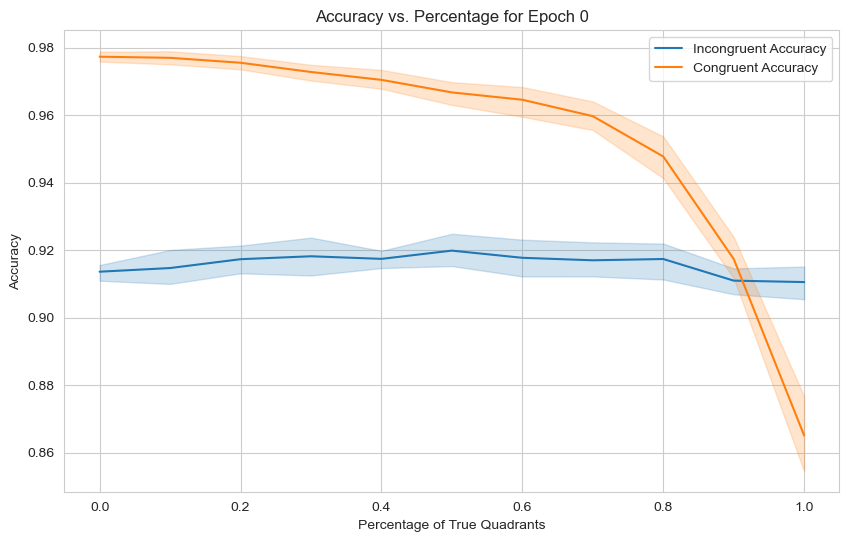

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows where epoch is 0
df_epoch0 = df_avg[df_avg['epoch'] == 0]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the line plot for incong_acc
sns.lineplot(x='complement_percentage', y='incong_acc', data=df_epoch0, label='Incongruent Accuracy')

# Create the line plot for cong_acc
sns.lineplot(x='complement_percentage', y='cong_acc', data=df_epoch0, label='Congruent Accuracy')

# Customize the plot
plt.title('Accuracy vs. Percentage for Epoch 0')
plt.xlabel('Percentage of True Quadrants')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
# Assume units, num_units, and percentage_true are already defined
# Define your quadrants conditions here
quadrants = {'Q1': False, 'Q2': True, 'Q3': False, 'Q4': True}

fit = pd.DataFrame(np.array([[units[i].coeff1, units[i].coeff2, units[i].r_sqrd] 
                              for i in range(len(units))]), columns=['coeff1','coeff2','rsqrd'])

# Define quadrant conditions
conditions = {
    'Q1': (fit['coeff1'] > 0) & (fit['coeff2'] > 0) & (fit['rsqrd'] > 0.9),
    'Q2': (fit['coeff1'] < 0) & (fit['coeff2'] > 0) & (fit['rsqrd'] > 0.9),
    'Q3': (fit['coeff1'] < 0) & (fit['coeff2'] < 0) & (fit['rsqrd'] > 0.9),
    'Q4': (fit['coeff1'] > 0) & (fit['coeff2'] < 0) & (fit['rsqrd'] > 0.9),
}

# Filter indices based on specified quadrants
selected_indices_true = [index for quad, cond in conditions.items() if quadrants.get(quad, False) for index in fit[cond].index]
selected_indices_false = [index for quad, cond in conditions.items() if not quadrants.get(quad, False) for index in fit[cond].index]

# Determine number of units to sample from each group
num_true = int(num_units * percentage_true)
num_false = num_units - num_true

# Check if there are enough units to sample from
if num_true > len(selected_indices_true):
    print(f"Not enough true units to sample from. Required: {num_true}, Available: {len(selected_indices_true)}")

if num_false > len(selected_indices_false):
    print(f"Not enough false units to sample from. Required: {num_false}, Available: {len(selected_indices_false)}")

# Randomly sample indices
random_indices_true = np.random.choice(selected_indices_true, num_true, replace=False) if num_true > 0 else []
random_indices_false = np.random.choice(selected_indices_false, num_false, replace=False) if num_false > 0 else []

# Combine indices
random_indices = np.concatenate([random_indices_true, random_indices_false])

In [26]:
net=1; relu=4; epoch=90

pkl_filename = f'../../pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'
print(f'Loading {pkl_filename}..')
with open(pkl_filename, 'rb') as f:
    units = pickle.load(f)

Loading ../../pkl/4to20/network1_Relu4_epoch90_4to20.pkl..


In [43]:
fit = pd.DataFrame([[units[i].coeff1, units[i].coeff2, units[i].r_sqrd] for i in range(len(units))])
Q2 = fit[(fit.iloc[:,0]<0)&(fit.iloc[:,1]>0)&(fit.iloc[:,2]>0.9)].index

In [42]:
Q4

Int64Index([ 2707,  2708,  2709,  2710,  2711,  2712,  2713,  2714,  2715,
             2716,
            ...
            64135, 64136, 64137, 64146, 64149, 64150, 64162, 64163, 64172,
            64363],
           dtype='int64', length=283)

In [47]:
Q4==3798

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,